In [2]:
import intake
import easygems.healpix as egh
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from datetime import datetime
import glob
import logging
import os
import pathlib
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})
import global3d_track as g3d
src = g3d.scripts.src

savedir = pathlib.Path('../figuresV3')
outdir = pathlib.Path(f'/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/')
os.makedirs(savedir, exist_ok=True)
os.makedirs(outdir, exist_ok=True)

In [3]:
dpi = 300
ext = 'pdf'

In [4]:
# load icon data
logging.info(f"{datetime.now()} loading model data")
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
globaldata = cat.ICON.ngc4008a(time="PT15M", zoom=9).to_dask().sel(time=slice('20210701','20210708'))

# subselect region
domain_extents = {"amazon": (277,317,-15,15),}
def cells_of_domain(ds, domain_name):
    lon_min, lon_max, lat_min, lat_max = domain_extents[domain_name]
    cells = ds.cell
    c1 = cells.where(ds.lon>lon_min).where(ds.lon<lon_max).where(ds.lat>lat_min).where(ds.lat<lat_max)
    return c1.dropna('cell')

c = cells_of_domain(globaldata.pipe(egh.attach_coords), domain_name='amazon')
data = globaldata.pipe(egh.attach_coords).sel(cell=c.astype(int))

INFO:root:2026-01-20 18:44:24.678554 loading model data


#### figure 1 - data snapshot

In [10]:
# load global

# time
d1 = cat.ICON.ngc4008(time="PT3H", zoom=9).to_dask().sel(time='20210704T2100')
d2 = cat.ICON.ngc4008a(time="PT15M", zoom=9).to_dask().sel(time=d1.time)

# area
ndegrees = .5
ds = src.utils.regrid.Regrid((0,360,-90,90)).perform(d1[['clivi','cllvi']], zoom=9, resolution=0.1)
ds_amaz = src.utils.regrid.Regrid('amazon').perform(d2[['rlut',]], zoom=9, resolution=0.1)

INFO:root:Region to regrid: (0, 360, -90, 90)
INFO:root:Region to regrid: (-83, -43, -15, 15)


In [11]:
def alpha_cmap(cmap='Blues', rev=0):
    cmap_vals = plt.get_cmap(cmap)(np.linspace(0, 1.0, 256))
    cmap_vals[:, -1] = np.linspace(0.5, 1, 256) if not rev else np.linspace(0, 1, 256)[::-1]
    return mpl.colors.ListedColormap(cmap_vals)
    
def add_cbars(ax, cb0, cb1, cb2):
    cbar = fig.colorbar(cb1, ax=ax, orientation='vertical', pad=0)
    cbar.set_label("Specific ice [kg kg$^{-1}$]", fontsize=10)
    cbar = fig.colorbar(cb2, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label("Specific liquid [kg kg$^{-1}$]", fontsize=10)
    cbar = fig.colorbar(cb0, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label("Vertical velcoity [m s$^{-1}$]", fontsize=10)

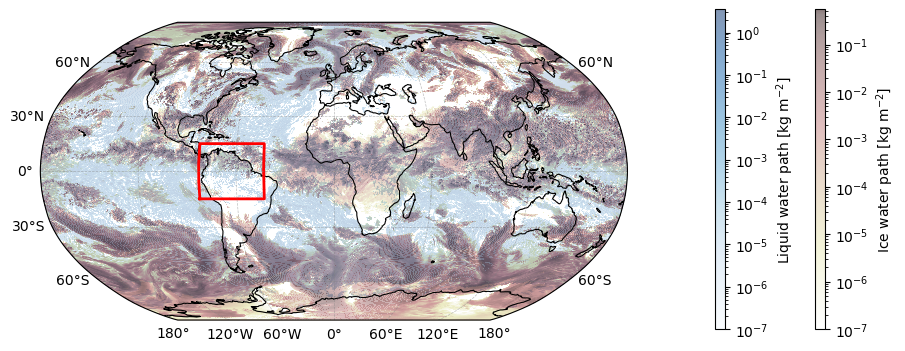

In [12]:
# prep

cmap_mask = mpl.colors.ListedColormap(plt.get_cmap('Reds')(np.linspace(0.25, 1, 100)))
levels = (1, 2, 3, 5, 10)
title_params = dict(fontsize=10)
extent = (ds.lon.min().item(), ds.lon.max().item(), -90, 90)
amz_extent = (ds_amaz.lon.min().item(), ds_amaz.lon.max().item(),
              ds_amaz.lat.min().item(), ds_amaz.lat.max().item())
fsize = 10

# fig
fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(1,2,width_ratios=[5,1])
ax1 = fig.add_subplot(gs[0], projection=ccrs.Robinson())

# plot 1
img1 = ds.cllvi.plot(ax=ax1, cmap='Blues', transform=ccrs.PlateCarree(), add_colorbar=False, norm=mpl.colors.LogNorm(), vmin=1e-7, alpha=.5)
img2 = ds.clivi.plot(ax=ax1, cmap='pink_r', transform=ccrs.PlateCarree(), add_colorbar=False, norm=mpl.colors.LogNorm(), vmin=1e-7, alpha=.5)

# add domain box
lon_min, lon_max, lat_min, lat_max = amz_extent
bbox_lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
bbox_lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
ax1.plot(bbox_lons, bbox_lats, transform=ccrs.PlateCarree(), color='r', linewidth=2)

# axes
# ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax1.coastlines(linewidth=0.8)
gl = ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax1.set_title(None)
ax1.set_title('', fontsize=fsize, loc='left')

# cbars
cax1 = fig.add_axes([0.8, 0.1, 0.01, 0.8])
cax2 = fig.add_axes([.9, 0.1, 0.01, 0.8])
cbar = fig.colorbar(img1, cax=cax1, orientation='vertical',)
cbar.set_label("Liquid water path [kg m$^{-2}$]", fontsize=10)
cbar = fig.colorbar(img2, cax=cax2, orientation='vertical',)
cbar.set_label("Ice water path [kg m$^{-2}$]", fontsize=10)

# fig
fig.savefig(savedir / f'figure_01.{ext}', bbox_inches='tight', dpi=dpi)

#### figure 3 - vertical velocity histograms

In [13]:
# load histograms
workdir = outdir / 'w_histograms'

def load_wa_hist(name):
    wa = np.zeros(999)
    for f in (workdir).glob(f"{name}-*"):
        wa += np.load(f)
    wa_bins = np.load(next(workdir.glob("w500_histogram_bins*")))
    return wa, wa_bins

w500, wa_bins = load_wa_hist('w500_histogram')
cloudy, _ = load_wa_hist('w500_histogram_cloudy')
not_cloudy, _ = load_wa_hist('w500_histogram_not_cloudy')
very_cloudy, _ = load_wa_hist('w500_histogram_very_cloudy')
not_very_cloudy, _ = load_wa_hist('w500_histogram_not_very_cloudy')


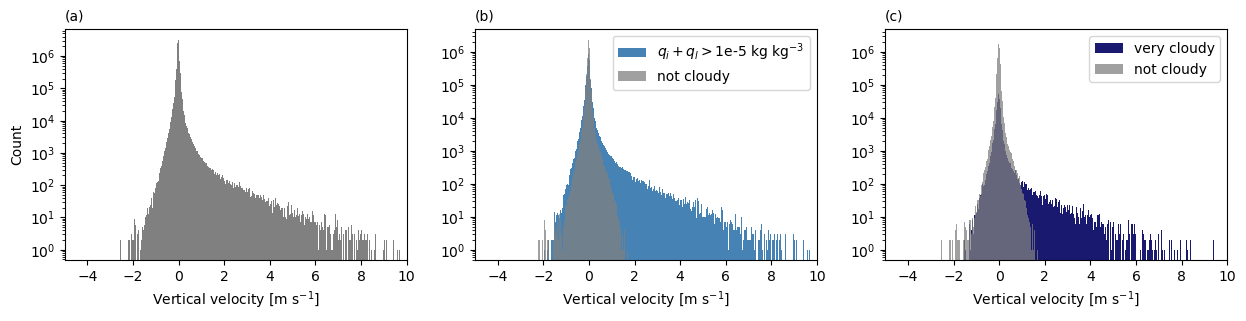

In [14]:
fs = 10
fig, axs = plt.subplots(1,3, figsize=(15,3))

ax = axs[0]
ax.bar(wa_bins[:-1], w500, width=np.diff(wa_bins), fc='grey')
ax.set(xlim=(-5,10))
ax.set_title('(a)', loc='left', fontsize=fs)
ax.set_ylabel('Count', fontsize=fs)
ax.set_xlabel('Vertical velocity [m s$^{-1}$]', fontsize=fs)
ax.set_yscale('log')

ax = axs[1]
ax.bar(wa_bins[:-1], cloudy, width=np.diff(wa_bins), fc='steelblue', label='$q_i+q_l>$1e-5 kg kg$^{-3}$')
ax.bar(wa_bins[:-1], not_cloudy, width=np.diff(wa_bins), fc='grey', label='not cloudy', alpha=.75, )
ax.set(xlim=(-5,10))
ax.set_title('(b)', loc='left', fontsize=fs)
ax.set_xlabel('Vertical velocity [m s$^{-1}$]', fontsize=fs)
ax.set_yscale('log')
ax.legend()

ax = axs[2]
ax.bar(wa_bins[:-1], very_cloudy, width=np.diff(wa_bins), fc='midnightblue', label='very cloudy')
ax.bar(wa_bins[:-1], not_cloudy, width=np.diff(wa_bins), fc='grey', label='not cloudy', alpha=.75)
ax.set(xlim=(-5,10))
ax.set_title('(c)', loc='left', fontsize=fs)
ax.set_xlabel('Vertical velocity [m s$^{-1}$]', fontsize=fs)
ax.set_yscale('log')
ax.legend()

fig.savefig(savedir / f'figure_03.{ext}', dpi=dpi, bbox_inches='tight')

#### figure 7 - what got tracked

In [15]:
# load data
tracks_path = '/work/bb1153/b382635/data/final_tracks/updraft_ice_only/amazon/'
features_path = '/work/bb1153/b382635/data/final_tracks/amazon/'
tracks = glob.glob(tracks_path + '*/*system_tracks_linked_proc.nc')
pre_proc_tracks = glob.glob(tracks_path + '*/*system_tracks_linked.nc')
updrafts = glob.glob(features_path + '*/*updraft/segmented_mask.nc')
ice = glob.glob(features_path + '*/*ice/segmented_mask.nc')

tracks = xr.open_mfdataset(tracks)
pp_tracks = xr.open_mfdataset(pre_proc_tracks)
updrafts = xr.open_mfdataset(updrafts)
ice = xr.open_mfdataset(ice)

# to AMT time
tracks['time'] = tracks.time + pd.Timedelta(hours=-4)
pp_tracks['time'] = pp_tracks.time + pd.Timedelta(hours=-4)
updrafts['time'] = updrafts.time + pd.Timedelta(hours=-4)
ice['time'] = ice.time + pd.Timedelta(hours=-4)

In [16]:
# get area covered...

def get_area_covered(ds):
    grid_spacing = 11000 # m
    area = (ds>0).sum(('lat','lon')) * (grid_spacing**2)
    dirunal_mean = area.groupby(area.time.dt.hour).mean()
    return dirunal_mean

area_ds = xr.Dataset({'updrafts': get_area_covered(updrafts.feature>0),
                      'ice': get_area_covered(ice.feature>0),
                      'tracked_updrafts': get_area_covered(pp_tracks.u_tracks>0),
                      'tracked_ice': get_area_covered(pp_tracks.i_tracks>0),
                      'tracked_system': get_area_covered(tracks.system>0),
                      'dcc_ice': get_area_covered(tracks.i_tracks.where(tracks.system>0)>0),
                      'dcc_updraft': get_area_covered(tracks.u_tracks.where(tracks.system>0)>0),
                     })
area_ds = area_ds.compute() # force compute (takes >10 mins)

In [17]:
# get vertical coords in height (m)
zg = data.zg.mean('cell')
zg = zg / 1000 # m to km
area_ds = area_ds.assign_coords(dict(zg=zg))
area_ds = area_ds / 1e6 # to km^2

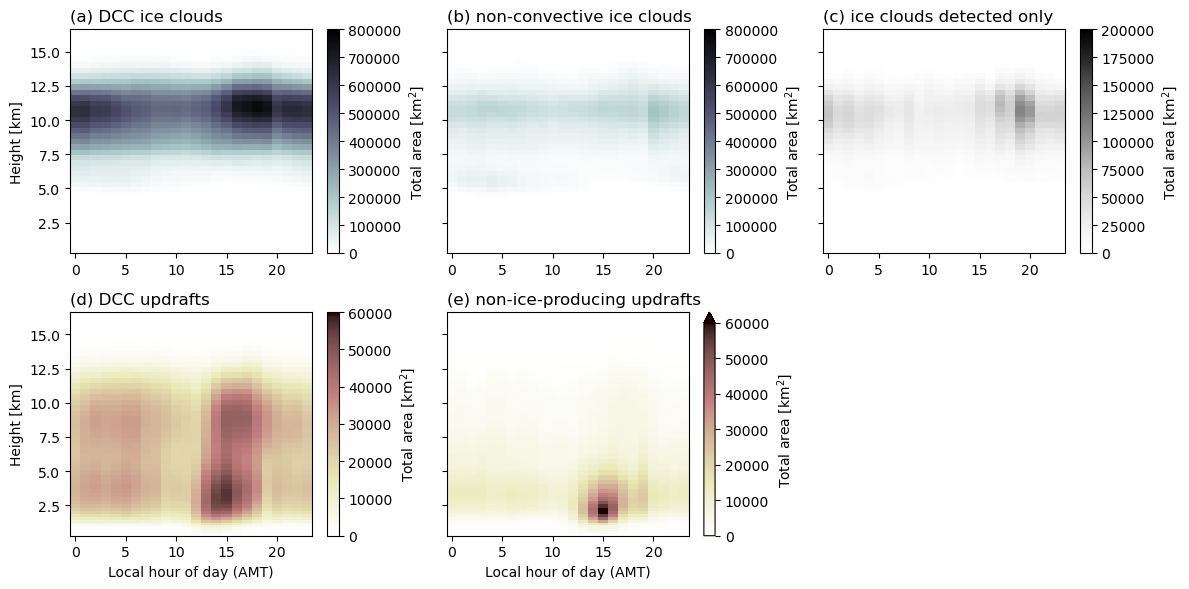

In [18]:
# plot
vmin_ice = 0
vmax_ice = 8e11 / 1e6
vmin_up = 0
vmax_up = 6e10 / 1e6

title_params = dict(loc='left', fontsize=12)

fig, axs = plt.subplots(2, 3, figsize=(12, 6), layout='tight', sharey=True)
top, bottom = axs

def plot_area(ax, data, vmin, vmax, title, cmap='Greys', cbar_kwargs={'label':'Total area [km$^2$]'}):
    im = data.plot(ax=ax, x='hour', y='zg', cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=1, cbar_kwargs=cbar_kwargs)
    ax.set_title(title, **title_params)
    return im

# --- ICE ---
plot_area(top[0], area_ds.dcc_ice, vmin_ice, vmax_ice, '(a) DCC ice clouds', cmap='bone_r')
plot_area(top[1], area_ds.tracked_ice - area_ds.dcc_ice , vmin_ice, vmax_ice, '(b) non-convective ice clouds', cmap='bone_r')
cbi = plot_area(top[2], area_ds.ice - area_ds.tracked_ice, vmin_ice, 2e11/1e6, '(c) ice clouds detected only', cmap='Greys')

# --- UPDRAFTS ---
plot_area(bottom[0], area_ds.dcc_updraft, vmin_up, vmax_up, '(d) DCC updrafts', cmap='pink_r')
cbw = plot_area(bottom[1], area_ds.tracked_updrafts - area_ds.dcc_updraft, vmin_up, vmax_up, '(e) non-ice-producing updrafts', cmap='pink_r')
bottom[2].axis('off')

# --- Axis labels ---
for ax in axs.flat:
    ax.set(title='', xlabel='', ylabel='')

for ax in bottom:
    ax.set_xlabel('Local hour of day (AMT)')

for ax in [top[0], bottom[0]]:
    ax.set_ylabel('Height [km]')

fig.savefig(savedir / f'figure_07.{ext}', bbox_inches='tight', dpi=dpi)

#### figure 8 - tracking results overview

In [5]:
# load all results
ex_tracks = '/work/bb1153/b382635/data/final_tracks/updraft_ice_only/amazon/20210701/20210701T0000_20210702T0000_system_tracks_linked_proc.nc'
mask_coords = xr.open_mfdataset(ex_tracks).drop_dims('time').coords
files = sorted(glob.glob('/work/bb1153/b382635/data/track_statistics/updraft_ice_only/amazon/first_bucket/*.nc'))
li = []
for f in files:
    li.append(xr.Dataset(coords=mask_coords).merge(xr.open_mfdataset(f))[['core_area', 'att','cloud_area']])
ds = xr.concat(li, dim='time')
ds = ds.where(ds != -999.99)

# drop invalid
df = pd.read_csv(outdir / 'system_validity.csv', index_col='system_id')
valid = df.index[np.logical_and(~df.hits_boundary, ~(df.dcc_first_tracked_above_freezing==True))]
ds_valid = ds.sel(system=ds.system.isin(valid))

In [6]:
# choose times to plot

t1 = pd.to_datetime("2021-07-01T16:00") # approx. 1600 in the Amazon
t2 = pd.to_datetime("2021-07-02T04:00") # approx. 0400 in the Amazon

In [7]:
# to lat lon
d = globaldata
d['time'] = d.time - pd.Timedelta(hours=4) # to AMT time
data = src.utils.regrid.Regrid('amazon').perform(d.sel(time=[t1,t2]), zoom=9, resolution=0.1)
data = src.utils.data_tools.preprocess_for_tobac(data).chunk({'time': 1, 'lat': 100, 'lon': 100})

INFO:root:Region to regrid: (-83, -43, -15, 15)


In [8]:
# compute IWP
iwp = src.statistics.calculations.calculate_IWP(data).compute()
lwp = src.statistics.calculations.calculate_xWP(data, 'clw').compute()

In [27]:
# compute tracking footprint
spatial_extents = (ds.att > 0) # booleen extent mask
n_cores = ds.core_area.max(('time')).count('core')
spatial_extents_scaled = (spatial_extents * n_cores).max('system')
spatial_extents_scaled = spatial_extents_scaled.sel(time=[t1,t2]).compute()

# get n clouds at each time
da = ds.cloud_area
n_systems = {}
n_systems[t1] = da.where(da > 0).sel(time=t1).dropna('system', how='all').system.size
n_systems[t2] = da.where(da > 0).sel(time=t2).dropna('system', how='all').system.size

# prep data for  timeseries 
mean_aca = ds_valid.cloud_area.mean('system').compute()
total_systems = (ds_valid.cloud_area>0).sum('system').compute()
n_cores_ = ds_valid.core_area.where(ds_valid.core_area>0).count(('core')).compute()
n_cores_time = n_cores_.sum('system') / total_systems # avg per system
n_cores_set_outliers = (n_cores_.where(n_cores_<10).sum('system') / total_systems).compute() # setting outliers as 10
mean_aca = mean_aca / 1e6 # convert units [m2] -> [km2]

In [28]:
n_systems

{Timestamp('2021-07-01 16:00:00'): 50, Timestamp('2021-07-02 04:00:00'): 41}

In [29]:
# plot prep

cmap_mask = mpl.colors.ListedColormap(plt.get_cmap('Reds')(np.linspace(0.25, 1, 100)))
levels = (1, 2, 3, 5, 10)
iwp_cmap = plt.get_cmap('Blues')
# iwp_cmap.set_under()
title_params = dict(fontsize=12)
extent = (ds.lon.min().item(), ds.lon.max().item(),
          ds.lat.min().item(), ds.lat.max().item())

def plot_snapshot(ax, data, t, title=None, cmap=iwp_cmap, params={'cmap':iwp_cmap, }, setup=1):
    # Plot IWP
    img = data.sel(time=t).plot(ax=ax, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree(), add_colorbar=0, vmin=1e-4, **params)
    
    # Plot mask contours
    if setup:
        d = spatial_extents_scaled.sel(time=t)
        cs = d.plot.contour(ax=ax, levels=levels, cmap=cmap_mask,
                            transform=ccrs.PlateCarree(), linewidths=1.5)
        
        # Axes setup
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.8)
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}
        
        # title
        t_str = d.time.dt.strftime('%b-%d %H:%M UTC').item()
        n_clouds = n_systems[t]
        title_str = title % n_clouds if title else f'{t_str}: {n_clouds:3d} clouds'
        ax.set_title(title_str, loc='left', **title_params)

        return cs, img
    else:
        return _, img

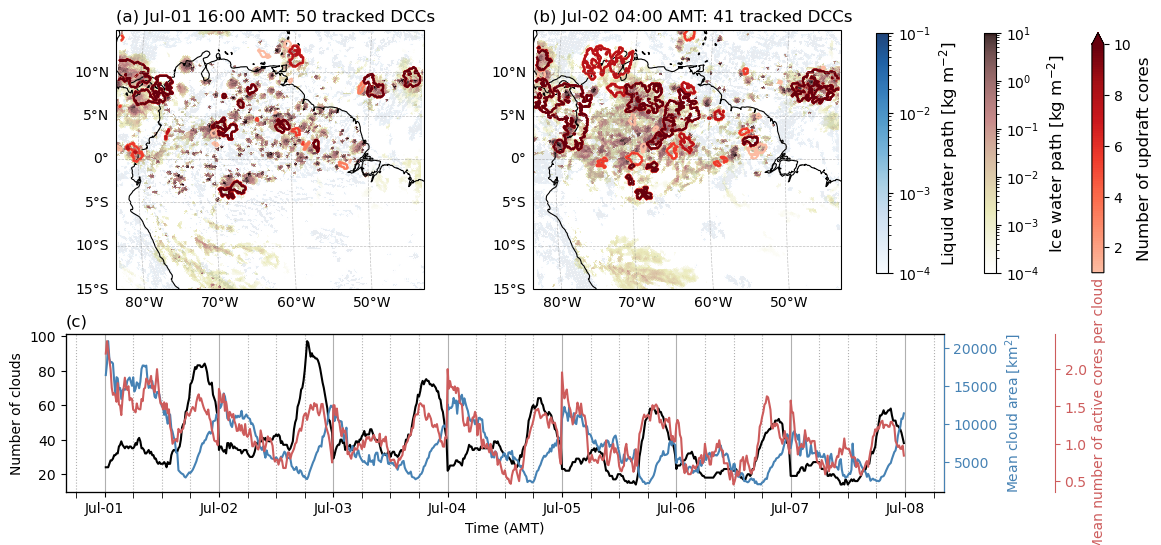

In [32]:
# fig
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(14,18, figure=fig)
ax1 = fig.add_subplot(gs[0:8,0:8], projection=ccrs.Robinson())
ax2 = fig.add_subplot(gs[0:8,8:16], projection=ccrs.Robinson())
ax3 = fig.add_subplot(gs[9:,:17])

# plot top
_, _ = plot_snapshot(ax1, lwp, t1, f"(a) {t1.strftime('%b-%d')} 16:00 AMT: %s tracked DCCs", params=dict(cmap='Blues', alpha=.9, vmax=.1))
_, _ = plot_snapshot(ax1, iwp, t1, f"(b) {t1.strftime('%b-%d')} 04:00 AMT: %s tracked DCCs", params=dict(cmap='pink_r', alpha=.9, vmax=1e1), setup=0)
cs1, img1 = plot_snapshot(ax2, lwp, t2, f"(b) {t2.strftime('%b-%d')} 04:00 AMT: %s tracked DCCs", params=dict(cmap='Blues', alpha=.9, vmax=.1))
cs2, img2 = plot_snapshot(ax2, iwp, t2, f"(b) {t2.strftime('%b-%d')} 04:00 AMT: %s tracked DCCs", params=dict(cmap='pink_r', alpha=.9, vmax=1e1), setup=0)

# cbar 1
h, w = 0.4, 0.01
cax = fig.add_axes([0.89, 0.475, w, h])
cb = fig.colorbar(img2, cax=cax)
cb.ax.set_ylabel('Ice water path [kg m$^{-2}$]', **title_params)
cb.ax.tick_params(labelsize=10)

# cbar 1
cax = fig.add_axes([0.8, 0.475, w, h])
cb = fig.colorbar(img1, cax=cax)
cb.ax.set_ylabel('Liquid water path [kg m$^{-2}$]', **title_params)
cb.ax.tick_params(labelsize=10)

# cbar 2
cax = fig.add_axes([0.98, 0.475, w, h])
norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap_mask)
cb = fig.colorbar(sm, cax=cax, extend='max')
cb.ax.set_ylabel('Number of updraft cores', **title_params)
cb.ax.tick_params(labelsize=10)

for ax in (ax1,ax2):
    ax.set(title='')

# plot bottom
fsize=10
ax = ax3
axt = ax.twinx()
c = 'steelblue'
src.utils.analysis_tools.color_axis(axt, color=c, pad=0)
axt2 = ax.twinx()
c2 = 'indianred'
src.utils.analysis_tools.color_axis(axt2, color=c2, pad=80)

# data
n_cores_time.plot(ax=axt2, color=c2, ls='-')#(0, (1,1)))
mean_aca.plot(ax=axt, color=c, ls='-')#(5, (10,3)))
total_systems.plot(ax=ax, color='k', ls='-')

# format
ax.set_ylabel('Number of clouds', fontsize=fsize, color='k')
ax.tick_params(axis='y', labelcolor='k', labelsize=fsize)
ax.tick_params(axis='x', labelsize=fsize)
ax.set_xlabel('Time (AMT)', fontsize=fsize)
axt.set_ylabel(r'Mean cloud area [km$^2$]', fontsize=fsize, color=c)
axt2.set_ylabel(r'Mean number of active cores per cloud', fontsize=fsize, color=c2)
axt.tick_params(axis='y', labelcolor=c, labelsize=fsize)
ax.xaxis.set_major_locator(mpl.dates.DayLocator())  # e.g., 1-day major ticks
ax.xaxis.set_minor_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))  # 6-hour minor ticks
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b-%d'))
ax.tick_params(axis='x', which='minor', length=4, labelsize=8)
ax.grid(axis='x',which='minor', ls=':')
ax.grid(axis='x',which='major')

# Titles and grid
ax.set_title('(c)', loc='left', **title_params)

# fig
fig.subplots_adjust(hspace=0.5)
fig.savefig(savedir / f'figure_08.{ext}', bbox_inches='tight', dpi=dpi)

#### calculations for figure 10 - thermodynamic profiles

In [4]:
# random sample
data_sample = data[['ta','zg']].isel(cell=np.random.randint(0,data.cell.size,100000), time=np.random.randint(0,data.time.size,100))
ta = data_sample.ta
z_prof = data_sample.zg.mean(('cell'))

In [6]:
# calculate and save
temperature_profile = xr.Dataset({'ta_mean':ta.mean(('time','cell')),
                                   'ta_min':ta.min(('time','cell')),
                                   'ta_max':ta.max(('time','cell')),
                                   'z_mean':z_prof / 1000}) # to km
temperature_profile.to_netcdf(outdir / "domain_mean_temperature_profile.nc")